## Case 1

### Data Analysis

In [30]:
# main.py
import wandb
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import yaml

CV_SPLITS = 5
MAX_ITER = 100000

def objective_elastic(config=None):
    with wandb.init(config=config):
        config = wandb.config
        alpha = config.alpha
        l1_ratio = config.l1_ratio
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,max_iter=MAX_ITER, random_state=42)
        scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
        mean_score = np.sqrt(-np.mean(scores))
        wandb.log({"root_mean_mse": mean_score})
        return mean_score

def objective_ridge(config=None):
    with wandb.init(config=config):
        config = wandb.config
        alpha = config.alpha
        model = Ridge(alpha=alpha,max_iter=MAX_ITER, random_state=42)
        scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
        mean_score = np.sqrt(-np.mean(scores))
        wandb.log({"alpha": config.alpha, "root_mean_mse": mean_score})
        return mean_score

def objective_lasso(config=None):
    with wandb.init(config=config):
        config = wandb.config
        alpha = config.alpha
        model = Lasso(alpha=alpha, random_state=42)
        scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
        mean_score = np.sqrt(-np.mean(scores))
        wandb.log({"alpha": config.alpha, "root_mean_mse": mean_score})
        return mean_score



# Load data and preprocess
data = pd.read_csv('case1Data.csv')
#data = data.drop('C_02', axis=1)
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

from sklearn.linear_model import LinearRegression

from scipy import stats

def fill_nan(X, method='mean'):
    """Fill NaN values in a 2D array using the specified method"""
    if method == 'mean':
        column_means = np.nanmean(X, axis=0)
        nan_matrix = np.isnan(X)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    elif method == 'round_mean':
        column_means = np.nanmean(X, axis=0)
        nan_matrix = np.isnan(X)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
        #last 4 columns are categorical, round off to nearest
        X[:, -4:] = np.round(X[:, -4:])
    elif method == 'regression':
        nan_matrix = np.isnan(X)
        column_means = np.nanmean(X, axis=0)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
        for col in range(X.shape[1]):
            missing_rows = np.where(nan_matrix[:, col])[0]

            if len(missing_rows) > 0:
                corr_matrix = np.corrcoef(X.T)
                corr_matrix = np.nan_to_num(corr_matrix)

                correlation = np.abs(corr_matrix[col])
                sorted_indices = np.argsort(-correlation)
                correlated_indices = [idx for idx in sorted_indices if idx != col][:5]

                valid_rows = ~np.any(nan_matrix[:, correlated_indices], axis=1)
                X_train_local, y_train_local = X[valid_rows][:, correlated_indices], X[valid_rows][:, col]

                if len(X_train_local) > 0:
                    model = LinearRegression()
                    model.fit(X_train_local, y_train_local)

                    X_test = X[missing_rows][:, correlated_indices]
                    X[missing_rows, col] = model.predict(X_test)
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    #split X into continuous and categorical
    X[:, -4:] = X[:, -4:].astype(int)

    #standardize continuous features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])

    # One-hot encode the categorical features
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    X = np.concatenate((X[:, :-4], X_cat), axis=1)
    return X

X = standardize_data(X)


In [31]:
if __name__ == "__main__":
    COUNT = 30
    # Elastic sweep
    with open('sweep_configs/ElasticSweep.yaml', 'r') as file:
        elastic_sweep_config = yaml.safe_load(file)

    elastic_sweep_id = wandb.sweep(elastic_sweep_config, project="case1")
    wandb.agent(elastic_sweep_id, objective_elastic, count=COUNT)

    # Ridge sweep
    with open('sweep_configs/RidgeSweep.yaml', 'r') as file:
        ridge_sweep_config = yaml.safe_load(file)
    
    ridge_sweep_id = wandb.sweep(ridge_sweep_config, project="case1")
    wandb.agent(ridge_sweep_id, objective_ridge, count=COUNT)

    # Lasso sweep
    with open('sweep_configs/LassoSweep.yaml', 'r') as file:
        lasso_sweep_config = yaml.safe_load(file)
    
    lasso_sweep_id = wandb.sweep(lasso_sweep_config, project="case1")
    wandb.agent(lasso_sweep_id, objective_lasso, count=COUNT)
    

Create sweep with ID: gj9euxsf
Sweep URL: https://wandb.ai/otovo-dtu-qa/case1/sweeps/gj9euxsf


wandb: Agent Starting Run: 2uhm43r1 with config:
wandb: 	alpha: 3.972249139082783
wandb: 	l1_ratio: 0.7436288244439955


root_mean_mse,▁
root_mean_mse,49.04858


wandb: Agent Starting Run: j5duudn2 with config:
wandb: 	alpha: 4.864883431646417
wandb: 	l1_ratio: 0.7480471914464674


root_mean_mse,▁
root_mean_mse,51.27394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 69prxujf with config:
wandb: 	alpha: 1.8131875399383723
wandb: 	l1_ratio: 0.21069084958931628


root_mean_mse,▁
root_mean_mse,49.01875


wandb: Agent Starting Run: tv2g7wup with config:
wandb: 	alpha: 1.6727006041326615
wandb: 	l1_ratio: 0.9213640604003268


root_mean_mse,▁
root_mean_mse,36.17812


wandb: Agent Starting Run: f7f06eps with config:
wandb: 	alpha: 1.106051019035698
wandb: 	l1_ratio: 0.9740228429709537


root_mean_mse,▁
root_mean_mse,32.94081


wandb: Agent Starting Run: k1fby9cw with config:
wandb: 	alpha: 0.12933471223599832
wandb: 	l1_ratio: 0.9736544193307832


root_mean_mse,▁
root_mean_mse,33.28687


wandb: Agent Starting Run: stw2atmw with config:
wandb: 	alpha: 0.7992695979822987
wandb: 	l1_ratio: 0.9968831707699022


root_mean_mse,▁
root_mean_mse,31.59752


wandb: Agent Starting Run: edvya5zr with config:
wandb: 	alpha: 0.6449196934979897
wandb: 	l1_ratio: 0.956254520030746


root_mean_mse,▁
root_mean_mse,32.06089


wandb: Agent Starting Run: e53bks1n with config:
wandb: 	alpha: 0.033914907177234735
wandb: 	l1_ratio: 0.6380963154374845


root_mean_mse,▁
root_mean_mse,35.11848


wandb: Agent Starting Run: pxqq06ip with config:
wandb: 	alpha: 0.5816967297037636
wandb: 	l1_ratio: 0.9849276504483916


root_mean_mse,▁
root_mean_mse,32.00534


wandb: Agent Starting Run: r46f7kqk with config:
wandb: 	alpha: 0.33802704509775566
wandb: 	l1_ratio: 0.816496203525691


root_mean_mse,▁
root_mean_mse,33.71665


wandb: Agent Starting Run: cm9945z0 with config:
wandb: 	alpha: 0.693940325685835
wandb: 	l1_ratio: 0.9990104921780604


root_mean_mse,▁
root_mean_mse,31.48331


wandb: Agent Starting Run: 38ytzxd4 with config:
wandb: 	alpha: 4.896920648508618
wandb: 	l1_ratio: 0.01739678597288563


root_mean_mse,▁
root_mean_mse,58.81892


wandb: Agent Starting Run: nfew00tl with config:
wandb: 	alpha: 2.275289741095997e-05
wandb: 	l1_ratio: 0.0001812551583324495


root_mean_mse,▁
root_mean_mse,48.42249


wandb: Agent Starting Run: i7bkxsx0 with config:
wandb: 	alpha: 0.9851716174433144
wandb: 	l1_ratio: 0.6959677777287618


root_mean_mse,▁
root_mean_mse,38.46224


wandb: Agent Starting Run: k33rfz80 with config:
wandb: 	alpha: 2.3953636967487304
wandb: 	l1_ratio: 0.998955664323844


root_mean_mse,▁
root_mean_mse,33.68646


wandb: Agent Starting Run: ipe3rvfm with config:
wandb: 	alpha: 3.242641376415697
wandb: 	l1_ratio: 0.9883041883532356


root_mean_mse,▁
root_mean_mse,34.2601


wandb: Agent Starting Run: cgzwg8xe with config:
wandb: 	alpha: 4.576522133095512
wandb: 	l1_ratio: 0.998939864635614


root_mean_mse,▁
root_mean_mse,33.28569


wandb: Agent Starting Run: olgtvvn1 with config:
wandb: 	alpha: 4.965870371250032
wandb: 	l1_ratio: 0.9932434699104464


root_mean_mse,▁
root_mean_mse,34.14614


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vgrkocxo with config:
wandb: 	alpha: 0.010757466679225738
wandb: 	l1_ratio: 0.43082185509783466


root_mean_mse,▁
root_mean_mse,36.66891


wandb: Agent Starting Run: t7nqeu84 with config:
wandb: 	alpha: 3.9318568466131407
wandb: 	l1_ratio: 0.9991217484031344


root_mean_mse,▁
root_mean_mse,33.23525


wandb: Agent Starting Run: 1m33vt5e with config:
wandb: 	alpha: 0.02592167978610836
wandb: 	l1_ratio: 0.8523260494716561


root_mean_mse,▁
root_mean_mse,35.62709


wandb: Agent Starting Run: 494ofklt with config:
wandb: 	alpha: 0.6603563678148835
wandb: 	l1_ratio: 0.8781962018604615


root_mean_mse,▁
root_mean_mse,33.58875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zvmnlhip with config:
wandb: 	alpha: 0.6915507692947167
wandb: 	l1_ratio: 0.9875234071162272


root_mean_mse,▁
root_mean_mse,31.78779


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6anv9e3p with config:
wandb: 	alpha: 1.8898239287871663
wandb: 	l1_ratio: 0.9973220166942204


root_mean_mse,▁
root_mean_mse,33.48327


wandb: Agent Starting Run: 85f4dqjz with config:
wandb: 	alpha: 1.2868088761499854
wandb: 	l1_ratio: 0.999699836893718


root_mean_mse,▁
root_mean_mse,32.3772


wandb: Agent Starting Run: 1eeaoxpx with config:
wandb: 	alpha: 0.2663371450960176
wandb: 	l1_ratio: 0.995561312276424


root_mean_mse,▁
root_mean_mse,32.66169


wandb: Agent Starting Run: 8q8dx8yq with config:
wandb: 	alpha: 0.41557943748533566
wandb: 	l1_ratio: 0.9466298504910824


root_mean_mse,▁
root_mean_mse,32.02324


wandb: Agent Starting Run: 16ethf7l with config:
wandb: 	alpha: 0.5302537048185468
wandb: 	l1_ratio: 0.5230592554938343


root_mean_mse,▁
root_mean_mse,37.72894


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n7mqit33 with config:
wandb: 	alpha: 0.429029671010202
wandb: 	l1_ratio: 0.8948561711897045


root_mean_mse,▁
root_mean_mse,32.72983


Create sweep with ID: hskoeypd
Sweep URL: https://wandb.ai/otovo-dtu-qa/case1/sweeps/hskoeypd


wandb: Agent Starting Run: oqrwgpcj with config:
wandb: 	alpha: 2.5014534586328394


alpha,▁
root_mean_mse,▁
alpha,2.50145
root_mean_mse,35.13449


wandb: Agent Starting Run: 3mfc54r3 with config:
wandb: 	alpha: 2.1728802207065567


alpha,▁
root_mean_mse,▁
alpha,2.17288
root_mean_mse,35.25115


wandb: Agent Starting Run: ivwrqn9i with config:
wandb: 	alpha: 1.932554950721593


alpha,▁
root_mean_mse,▁
alpha,1.93255
root_mean_mse,35.36642


wandb: Agent Starting Run: 3bstpeqx with config:
wandb: 	alpha: 3.627966367418375


alpha,▁
root_mean_mse,▁
alpha,3.62797
root_mean_mse,34.96743


wandb: Agent Starting Run: 88qavj6w with config:
wandb: 	alpha: 3.3273715244121647


alpha,▁
root_mean_mse,▁
alpha,3.32737
root_mean_mse,34.98588


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a3pfycip with config:
wandb: 	alpha: 4.339685920720297


alpha,▁
root_mean_mse,▁
alpha,4.33969
root_mean_mse,34.97322


wandb: Agent Starting Run: fqsbb52u with config:
wandb: 	alpha: 4.9953584220451


alpha,▁
root_mean_mse,▁
alpha,4.99536
root_mean_mse,35.02206


wandb: Agent Starting Run: fkjo49sg with config:
wandb: 	alpha: 3.979026580106684


alpha,▁
root_mean_mse,▁
alpha,3.97903
root_mean_mse,34.96277


wandb: Agent Starting Run: zsjk98v9 with config:
wandb: 	alpha: 3.82157450121096


alpha,▁
root_mean_mse,▁
alpha,3.82157
root_mean_mse,34.96285


wandb: Agent Starting Run: wy7jjg8v with config:
wandb: 	alpha: 4.12490225858513


alpha,▁
root_mean_mse,▁
alpha,4.1249
root_mean_mse,34.96533


wandb: Agent Starting Run: 9g1hqmc4 with config:
wandb: 	alpha: 3.900702919180525


alpha,▁
root_mean_mse,▁
alpha,3.9007
root_mean_mse,34.96243


wandb: Agent Starting Run: 9bxc0sqx with config:
wandb: 	alpha: 3.748940308087835


alpha,▁
root_mean_mse,▁
alpha,3.74894
root_mean_mse,34.96395


wandb: Agent Starting Run: g5lvoj4s with config:
wandb: 	alpha: 3.936862870393989


alpha,▁
root_mean_mse,▁
alpha,3.93686
root_mean_mse,34.96249


wandb: Agent Starting Run: gl53pv6o with config:
wandb: 	alpha: 3.8743776099743608


alpha,▁
root_mean_mse,▁
alpha,3.87438
root_mean_mse,34.96248


wandb: Agent Starting Run: ta9qdrk0 with config:
wandb: 	alpha: 4.036144961699428


alpha,▁
root_mean_mse,▁
alpha,4.03614
root_mean_mse,34.96349


wandb: Agent Starting Run: dko9csn1 with config:
wandb: 	alpha: 3.918591909303237


alpha,▁
root_mean_mse,▁
alpha,3.91859
root_mean_mse,34.96244


wandb: Agent Starting Run: eb573xr8 with config:
wandb: 	alpha: 3.852697641152855


alpha,▁
root_mean_mse,▁
alpha,3.8527
root_mean_mse,34.96259


wandb: Agent Starting Run: 57vveciq with config:
wandb: 	alpha: 3.8875097864156833


alpha,▁
root_mean_mse,▁
alpha,3.88751
root_mean_mse,34.96244


wandb: Agent Starting Run: qrku4j0n with config:
wandb: 	alpha: 3.906602971360849


alpha,▁
root_mean_mse,▁
alpha,3.9066
root_mean_mse,34.96243


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 19bc0mfj with config:
wandb: 	alpha: 3.954830982363601


alpha,▁
root_mean_mse,▁
alpha,3.95483
root_mean_mse,34.96259


wandb: Agent Starting Run: oa8v07ex with config:
wandb: 	alpha: 3.898224167865054


alpha,▁
root_mean_mse,▁
alpha,3.89822
root_mean_mse,34.96243


wandb: Agent Starting Run: 02n7dq3p with config:
wandb: 	alpha: 3.905834427363434


alpha,▁
root_mean_mse,▁
alpha,3.90583
root_mean_mse,34.96243


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9jx215ly with config:
wandb: 	alpha: 3.910310947680817


alpha,▁
root_mean_mse,▁
alpha,3.91031
root_mean_mse,34.96243


wandb: Agent Starting Run: q7zne5lt with config:
wandb: 	alpha: 3.891849643669488


alpha,▁
root_mean_mse,▁
alpha,3.89185
root_mean_mse,34.96243


wandb: Agent Starting Run: 90f3mrzb with config:
wandb: 	alpha: 3.927627309367912


alpha,▁
root_mean_mse,▁
alpha,3.92763
root_mean_mse,34.96246


wandb: Agent Starting Run: 666ogahu with config:
wandb: 	alpha: 3.903847921652896


alpha,▁
root_mean_mse,▁
alpha,3.90385
root_mean_mse,34.96242


wandb: Agent Starting Run: 6jffis9t with config:
wandb: 	alpha: 3.8999170036844584


alpha,▁
root_mean_mse,▁
alpha,3.89992
root_mean_mse,34.96243


wandb: Agent Starting Run: vj3yidh3 with config:
wandb: 	alpha: 3.913429582684145


alpha,▁
root_mean_mse,▁
alpha,3.91343
root_mean_mse,34.96243


wandb: Agent Starting Run: 62r1rsub with config:
wandb: 	alpha: 3.8954228911830913


alpha,▁
root_mean_mse,▁
alpha,3.89542
root_mean_mse,34.96243


wandb: Agent Starting Run: o75xzy04 with config:
wandb: 	alpha: 3.9107890897866606


alpha,▁
root_mean_mse,▁
alpha,3.91079
root_mean_mse,34.96243


Create sweep with ID: q4jbttli
Sweep URL: https://wandb.ai/otovo-dtu-qa/case1/sweeps/q4jbttli


wandb: Agent Starting Run: g7hs5x9v with config:
wandb: 	alpha: 4.62857120362615


alpha,▁
root_mean_mse,▁
alpha,4.62857
root_mean_mse,33.18432


wandb: Agent Starting Run: 8qytg8zm with config:
wandb: 	alpha: 2.2073787980000668


alpha,▁
root_mean_mse,▁
alpha,2.20738
root_mean_mse,33.67343


wandb: Agent Starting Run: n4tlw0jd with config:
wandb: 	alpha: 4.623323102631468


alpha,▁
root_mean_mse,▁
alpha,4.62332
root_mean_mse,33.183


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cum7pi7q with config:
wandb: 	alpha: 4.137080043163378


alpha,▁
root_mean_mse,▁
alpha,4.13708
root_mean_mse,33.18764


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 82bubiyh with config:
wandb: 	alpha: 4.403590213730973


alpha,▁
root_mean_mse,▁
alpha,4.40359
root_mean_mse,33.15407


wandb: Agent Starting Run: 27czg54h with config:
wandb: 	alpha: 0.003282882391283918


c:\Users\khali\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+02, tolerance: 4.391e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\khali\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e+02, tolerance: 4.239e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\khali\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+02, toler

alpha,▁
root_mean_mse,▁
alpha,0.00328
root_mean_mse,41.06594


wandb: Agent Starting Run: bks3pk0k with config:
wandb: 	alpha: 3.067164016040149


alpha,▁
root_mean_mse,▁
alpha,3.06716
root_mean_mse,33.36802


wandb: Agent Starting Run: 9yhd2m1u with config:
wandb: 	alpha: 4.98486420150127


alpha,▁
root_mean_mse,▁
alpha,4.98486
root_mean_mse,33.3431


wandb: Agent Starting Run: qxuft8i1 with config:
wandb: 	alpha: 3.660480960482331


alpha,▁
root_mean_mse,▁
alpha,3.66048
root_mean_mse,33.18301


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h2zv1ywg with config:
wandb: 	alpha: 3.869576260069155


alpha,▁
root_mean_mse,▁
alpha,3.86958
root_mean_mse,33.1619


wandb: Agent Starting Run: ubhycc5i with config:
wandb: 	alpha: 2.6484794307297457


alpha,▁
root_mean_mse,▁
alpha,2.64848
root_mean_mse,33.59275


wandb: Agent Starting Run: pbbim3w7 with config:
wandb: 	alpha: 3.431687792861113


alpha,▁
root_mean_mse,▁
alpha,3.43169
root_mean_mse,33.23704


wandb: Agent Starting Run: 3auwbhlz with config:
wandb: 	alpha: 4.479455732331733


alpha,▁
root_mean_mse,▁
alpha,4.47946
root_mean_mse,33.15321


wandb: Agent Starting Run: k7laysg2 with config:
wandb: 	alpha: 4.306539714040279


alpha,▁
root_mean_mse,▁
alpha,4.30654
root_mean_mse,33.16478


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 10icyfmp with config:
wandb: 	alpha: 3.7843453375153326


alpha,▁
root_mean_mse,▁
alpha,3.78435
root_mean_mse,33.1655


wandb: Agent Starting Run: 5ep35gud with config:
wandb: 	alpha: 3.973219328140617


alpha,▁
root_mean_mse,▁
alpha,3.97322
root_mean_mse,33.16763


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3foq7g1g with config:
wandb: 	alpha: 4.444249868545423


alpha,▁
root_mean_mse,▁
alpha,4.44425
root_mean_mse,33.15036


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lmvxl7ng with config:
wandb: 	alpha: 4.454625446194645


alpha,▁
root_mean_mse,▁
alpha,4.45463
root_mean_mse,33.15083


wandb: Agent Starting Run: 13z4wb0k with config:
wandb: 	alpha: 4.433994900915034


alpha,▁
root_mean_mse,▁
alpha,4.43399
root_mean_mse,33.15044


wandb: Agent Starting Run: tu9zy00v with config:
wandb: 	alpha: 4.440474464101608


alpha,▁
root_mean_mse,▁
alpha,4.44047
root_mean_mse,33.15045


wandb: Agent Starting Run: ybkbi556 with config:
wandb: 	alpha: 4.5259102003832785


alpha,▁
root_mean_mse,▁
alpha,4.52591
root_mean_mse,33.16125


wandb: Agent Starting Run: nb4dlvkm with config:
wandb: 	alpha: 4.440093303311432


alpha,▁
root_mean_mse,▁
alpha,4.44009
root_mean_mse,33.15045


wandb: Agent Starting Run: maftfs4m with config:
wandb: 	alpha: 4.430351939327875


alpha,▁
root_mean_mse,▁
alpha,4.43035
root_mean_mse,33.15054


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ziiomg3i with config:
wandb: 	alpha: 4.443398686981204


alpha,▁
root_mean_mse,▁
alpha,4.4434
root_mean_mse,33.15046


wandb: Agent Starting Run: ajybmzdt with config:
wandb: 	alpha: 4.4468767606854955


alpha,▁
root_mean_mse,▁
alpha,4.44688
root_mean_mse,33.15038


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: foshbt50 with config:
wandb: 	alpha: 4.44086487053357


alpha,▁
root_mean_mse,▁
alpha,4.44086
root_mean_mse,33.15045


wandb: Agent Starting Run: f85pzw2n with config:
wandb: 	alpha: 4.437003269975021


alpha,▁
root_mean_mse,▁
alpha,4.437
root_mean_mse,33.15044


wandb: Agent Starting Run: vkarp12f with config:
wandb: 	alpha: 4.44628866981504


alpha,▁
root_mean_mse,▁
alpha,4.44629
root_mean_mse,33.15037


wandb: Agent Starting Run: ctsrhld2 with config:
wandb: 	alpha: 4.439615112770738


alpha,▁
root_mean_mse,▁
alpha,4.43962
root_mean_mse,33.15044


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ads4ra8m with config:
wandb: 	alpha: 4.361045332012113


alpha,▁
root_mean_mse,▁
alpha,4.36105
root_mean_mse,33.15884


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
CV_SPLITS = 5
alpha = 1.07
# kfold on whole dataset
model = Lasso(alpha=alpha, random_state=42)
scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)

model = Lasso(alpha=alpha, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)


31.966767972044803 27.197735225291055 36.73580071879855
29.188882048763634 24.60076784948811 33.776996248039154


In [9]:
# kfold on whole dataset with ridge
alpha = 4.789
model = Ridge(alpha=alpha, random_state=42)
scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)

model = Ridge(alpha=alpha, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)

32.393409748248466 26.812950151621127 37.97386934487581
34.824376906817555 29.88143392544241 39.7673198881927


In [10]:
# kfold on whole dataset with elastic
alpha = 1.041
l1_ratio = 0.9885
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
scores = cross_val_score(model, X, y, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)

model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=CV_SPLITS, scoring='neg_mean_squared_error')
mean_score = np.sqrt(-np.mean(scores))
std_dev = np.sqrt(np.var(np.sqrt(-scores)))
confidence_interval = 1.96 * std_dev / np.sqrt(CV_SPLITS)
# print the 95% conf interval
print(mean_score, mean_score - confidence_interval, mean_score + confidence_interval)


31.865708340285938 27.295098676103972 36.43631800446791
28.568180568648618 25.54778547644386 31.588575660853376


In [ ]:
#load in case1data_xnew.csv
data = pd.read_csv('case1Data_xnew.csv')
#data = data.drop('C_02', axis=1)
X_nan = np.array(data)

X_new = fill_nan(X_nan, method='round_mean')
X_new = standardize_data(X)

#Lasso model
alpha = 1.07
model = Lasso(alpha=alpha, random_state=42)
#fit to all data X
model.fit(X, y)
#predict on new data
y_pred = model.predict(X_new)
np.savetxt('case1Data_ynew.csv', y_pred
            , delimiter=',', fmt='%f')



Tuning Ridge...
Tuning Lasso...


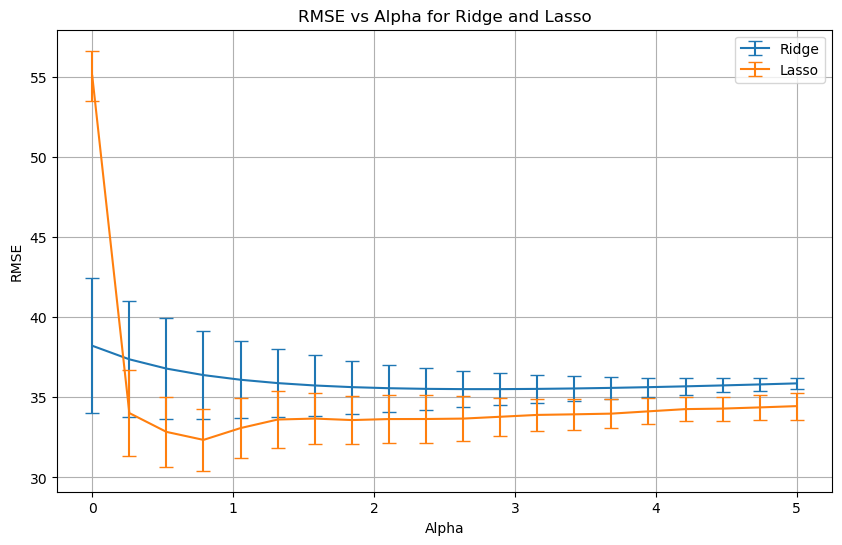

Final Results: {'Ridge': [38.218610848439724, 37.37202478410964, 36.7943241566321, 36.387672621247155, 36.09678720796015, 35.8880033436549, 35.73957878330515, 35.63679126114889, 35.56928043817809, 35.529521066597034, 35.511902066176226, 35.512147278740905, 35.526937644634124, 35.55365682006592, 35.5902150817824, 35.63492441568378, 35.68640798892341, 35.74353328596341, 35.805361888148326, 35.87111118904283], 'Lasso': [55.053854626024446, 34.01909908061767, 32.845441325312706, 32.345635937624365, 33.083004656586965, 33.61534518336692, 33.675297450609726, 33.582135596426326, 33.64499105978124, 33.64822694965802, 33.67366858517721, 33.78801096435047, 33.90333489776953, 33.94062421846182, 33.983706523663756, 34.12679521429831, 34.265852468906736, 34.29803344499194, 34.37201205265285, 34.45294238925319]}


In [ ]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
#import mean squared error as a metric
from sklearn.metrics import mean_squared_error

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Ridge": Ridge(max_iter=100000),
    "Lasso": Lasso(max_iter=100000)
}

param_grids = {
    "Ridge": {"alpha": np.linspace(1e-5, 5, 20)},
    "Lasso": {"alpha": np.linspace(1e-5, 5, 20)}
}

results = {}
rmse_means = []
rmse_stds = []
alphas = np.linspace(1e-5, 5, 20)

for name, model in models.items():
    print(f"Tuning {name}...")
    mean_rmses = []
    std_rmses = []
    
    for alpha in alphas:
        model.set_params(alpha=alpha)
        outer_scores = []
        
        for train_idx, test_idx in outer_cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            grid_search = GridSearchCV(model, {'alpha': [alpha]}, cv=inner_cv, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            test_score = mean_squared_error(y_test, y_pred)  # This gives MSE
            # test_score = -best_model.score(X_test, y_test)
            rmse = np.sqrt(test_score)  # This gives RMSE
            outer_scores.append(rmse)
        
        mean_rmses.append(np.mean(outer_scores))
        std_rmses.append(np.std(outer_scores))
    
    rmse_means.append(mean_rmses)
    rmse_stds.append(std_rmses)
    results[name] = mean_rmses
    
    # wandb.init(project="2-layer-kfold-grid-search")
    # for alpha, mean_rmse in zip(alphas, mean_rmses):
    #     wandb.log({"Model": name, "Alpha": alpha, "RMSE": mean_rmse})
    # wandb.finish()

# Plot RMSE vs Alpha
plt.figure(figsize=(10, 6))
for i, (name, mean_rmse) in enumerate(results.items()):
    plt.errorbar(alphas, mean_rmse, yerr=rmse_stds[i], label=name, capsize=5)

plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("RMSE vs Alpha for Ridge and Lasso")
plt.legend()
plt.grid()
plt.show()

print("Final Results:", results)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:55<00:00, 11.59s/it]


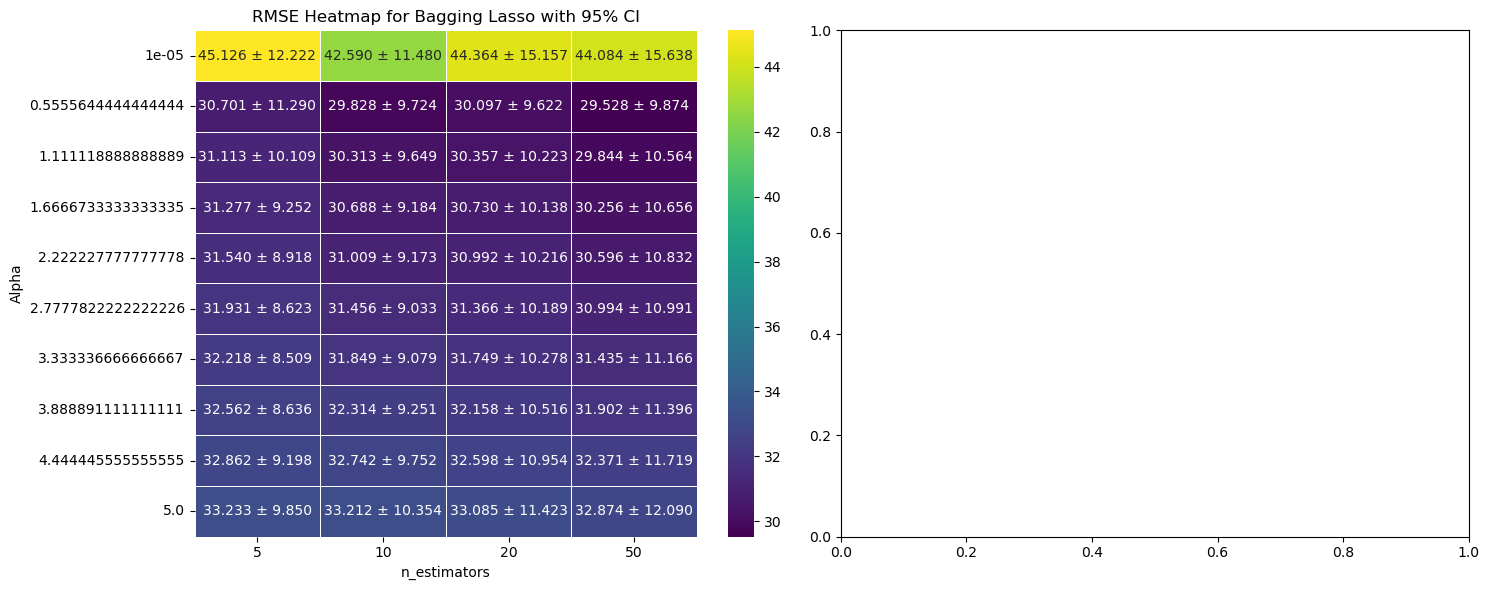

Final Results: {'Bagging Lasso': [(1e-05, 5, 45.126167613166224, 6.235581352891889), (1e-05, 10, 42.58987188403777, 5.857090119757792), (1e-05, 20, 44.3644168384857, 7.733399621679725), (1e-05, 50, 44.08406230287966, 7.978765324396429), (0.5555644444444444, 5, 30.700837687845052, 5.759966562376189), (0.5555644444444444, 10, 29.827755187112928, 4.961227569089501), (0.5555644444444444, 20, 30.096742827332015, 4.9090963214233785), (0.5555644444444444, 50, 29.528174201697176, 5.037970553523784), (1.111118888888889, 5, 31.113309954987777, 5.157500637460496), (1.111118888888889, 10, 30.312818354130183, 4.92282463353145), (1.111118888888889, 20, 30.357256687342147, 5.215847196789183), (1.111118888888889, 50, 29.843973663139046, 5.3896131085641645), (1.6666733333333335, 5, 31.27652190852052, 4.720461445182614), (1.6666733333333335, 10, 30.68809426057316, 4.685849500778899), (1.6666733333333335, 20, 30.730242894889567, 5.172653205310834), (1.6666733333333335, 50, 30.25571898206679, 5.4368184199

In [ ]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Bagging Lasso": BaggingRegressor(estimator=Lasso(max_iter=100000), random_state=42),
}

# Hyperparameter grid
alphas = np.linspace(1e-5, 5, 10)
#round alpha to 3 decimal places
alphas = np.round(alphas, 3)
n_estimators = [5, 10, 20, 50]
l1_ratios = np.linspace(0, 1, 5)  # Only for ElasticNet

results = {}

for model_name, model in models.items():
    model_results = []
    import tqdm
    for alpha in tqdm.tqdm(alphas):
        for n_est in n_estimators:
            if "ElasticNet" in model_name:
                for l1_ratio in l1_ratios:
                    model.set_params(estimator__alpha=alpha, estimator__l1_ratio=l1_ratio, n_estimators=n_est)
                    outer_scores = []
                    for train_idx, test_idx in outer_cv.split(X):
                        X_train, X_test = X[train_idx], X[test_idx]
                        y_train, y_test = y[train_idx], y[test_idx]
                        
                        grid_search = GridSearchCV(model, {'estimator__alpha': [alpha], 'estimator__l1_ratio': [l1_ratio], 'n_estimators': [n_est]}, cv=inner_cv, scoring='neg_mean_squared_error')
                        grid_search.fit(X_train, y_train)
                        best_model = grid_search.best_estimator_
                        y_pred = best_model.predict(X_test)
                        test_score = mean_squared_error(y_test, y_pred)  # MSE
                        rmse = np.sqrt(test_score)  # RMSE
                        outer_scores.append(rmse)
                    
                    mean_rmse = np.mean(outer_scores)
                    std_rmse = np.std(outer_scores)
                    model_results.append((alpha, n_est, l1_ratio, mean_rmse, std_rmse))
            else:
                model.set_params(estimator__alpha=alpha, n_estimators=n_est)
                outer_scores = []
                for train_idx, test_idx in outer_cv.split(X):
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    
                    grid_search = GridSearchCV(model, {'estimator__alpha': [alpha], 'n_estimators': [n_est]}, cv=inner_cv, scoring='neg_mean_squared_error')
                    grid_search.fit(X_train, y_train)
                    best_model = grid_search.best_estimator_
                    y_pred = best_model.predict(X_test)
                    test_score = mean_squared_error(y_test, y_pred)  # MSE
                    rmse = np.sqrt(test_score)  # RMSE
                    outer_scores.append(rmse)
                
                mean_rmse = np.mean(outer_scores)
                std_rmse = np.std(outer_scores)
                model_results.append((alpha, n_est, mean_rmse, std_rmse))
    
    results[model_name] = model_results

# Plot results
fig, axes = plt.subplots(1, 1, figsize=(15, 6))



for i, (model_name, model_results) in enumerate(results.items()):
    results_df = pd.DataFrame(model_results, columns=["Alpha", "n_estimators", "l1_ratio", "RMSE", "RMSE_Std"] if "ElasticNet" in model_name else ["Alpha", "n_estimators", "RMSE", "RMSE_Std"])
    results_df["CI"] = results_df["RMSE_Std"] * 1.96  # 95% Confidence Interval
    results_df["RMSE_CI"] = results_df.apply(lambda row: f'{row["RMSE"]:.3f} ± {row["CI"]:.3f}', axis=1)
    pivot_table = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE")
    pivot_labels = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE_CI")
    
    sns.heatmap(pivot_table, annot=pivot_labels, fmt="", cmap="viridis", linewidths=0.5, ax=axes[i])
    axes[i].set_xlabel("n_estimators")
    axes[i].set_ylabel("Alpha")
    axes[i].set_title(f"RMSE Heatmap for {model_name} with 95% CI")

plt.tight_layout()
plt.show()

print("Final Results:", results)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:50<00:00, 11.03s/it]


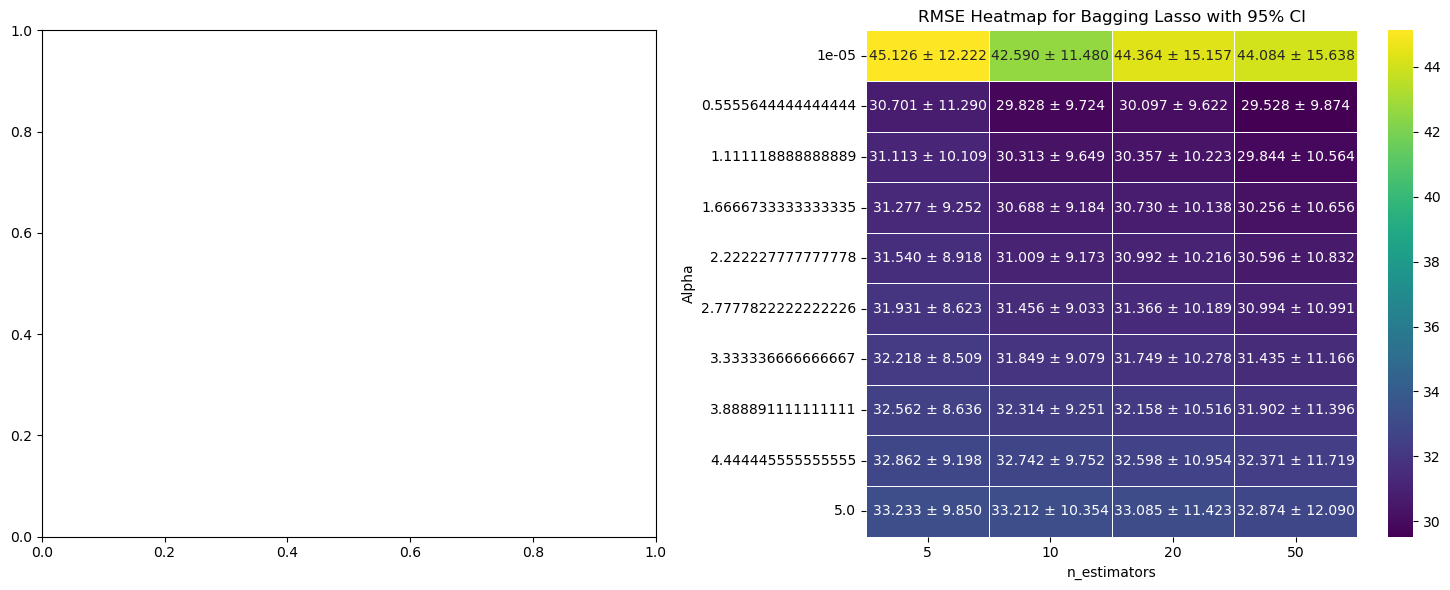

Final Results: {}


In [ ]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
#improt stacking regressor
from sklearn.ensemble import StackingRegressor
#import randomforest
from sklearn.ensemble import RandomForestRegressor

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Separate continuous and categorical feature indices
continuous_features = list(range(X.shape[1] - 5))  # Adjust as per your dataset
categorical_features = list(range(X.shape[1] - 5, X.shape[1]))  # Last 5 features

# Define models for Bagging Lasso and Decision Trees
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging_lasso', BaggingRegressor(estimator=Lasso(max_iter=100000), n_estimators=10, random_state=42))
])

tree_model = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('bagging_forest', BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=10, random_state=42))
])

# Meta-model for stacking
model = StackingRegressor(
    estimators=[('lasso', lasso_model), ('tree', tree_model)],
    final_estimator=Ridge(alpha=1.0)
)

# Hyperparameter grid
alphas = np.linspace(1e-5, 5, 10)
#round alpha to 3 decimal places
#alphas = np.round(alphas, 3)
n_estimators = [5, 10, 20, 50]
l1_ratios = np.linspace(0, 1, 5)  # Only for ElasticNet

results_stack = {}

for model_name, model in models.items():
    model_results = []
    import tqdm
    for alpha in tqdm.tqdm(alphas):
        for n_est in n_estimators:
            model.set_params(estimator__alpha=alpha, n_estimators=n_est)
            outer_scores = []
            for train_idx, test_idx in outer_cv.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                grid_search = GridSearchCV(model, {'estimator__alpha': [alpha], 'n_estimators': [n_est]}, cv=inner_cv, scoring='neg_mean_squared_error')
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_test)
                test_score = mean_squared_error(y_test, y_pred)  # MSE
                rmse = np.sqrt(test_score)  # RMSE
                outer_scores.append(rmse)
            
            mean_rmse = np.mean(outer_scores)
            std_rmse = np.std(outer_scores)
            model_results.append((alpha, n_est, mean_rmse, std_rmse))
    
    results_stack[model_name] = model_results

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))



for i, (model_name, model_results) in enumerate(results_stack.items()):
    results_df = pd.DataFrame(model_results, columns=["Alpha", "n_estimators", "RMSE", "RMSE_Std"])
    results_df["CI"] = results_df["RMSE_Std"] * 1.96  # 95% Confidence Interval
    results_df["RMSE_CI"] = results_df.apply(lambda row: f'{row["RMSE"]:.3f} ± {row["CI"]:.3f}', axis=1)
    pivot_table = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE")
    pivot_labels = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE_CI")
    sns.heatmap(pivot_table, annot=pivot_labels, fmt="", cmap="viridis", linewidths=0.5, ax=axes[1])
    axes[1].set_xlabel("n_estimators")
    axes[1].set_ylabel("Alpha")
    axes[1].set_title(f"RMSE Heatmap for {model_name} with 95% CI")

plt.tight_layout()
plt.show()

print("Final Results:", results)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.pipeline import Pipeline
import tqdm

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Separate continuous and categorical feature indices
continuous_features = list(range(X.shape[1] - 5))  # Adjust as per your dataset
categorical_features = list(range(X.shape[1] - 5, X.shape[1]))  # Last 5 features

# Define models for Bagging Lasso and Decision Trees
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging_lasso', BaggingRegressor(estimator=Lasso(max_iter=100000), n_estimators=10, random_state=42))
])

tree_model = Pipeline([
    ('bagging_forest', BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=10, random_state=42))
])

# Meta-model for stacking
model = StackingRegressor(
    estimators=[('lasso', lasso_model), ('tree', tree_model)],
    final_estimator=Ridge(alpha=1.0)
)

# Hyperparameter grid
alphas = np.linspace(1e-5, 5, 10)
n_estimators = [5, 10, 20]

results_stack = {}
models = {'StackingRegressor': model}

for model_name, model in models.items():
    model_results = []
    for alpha in tqdm.tqdm(alphas):
        for n_est in n_estimators:
            model.set_params(lasso__bagging_lasso__estimator__alpha=alpha, lasso__bagging_lasso__n_estimators=n_est, tree__bagging_forest__n_estimators = n_est)
            outer_scores = []
            for train_idx, test_idx in outer_cv.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                grid_search = GridSearchCV(model, param_grid={'lasso__bagging_lasso__estimator__alpha': [alpha],'lasso__bagging_lasso__n_estimators':[n_est], 'tree__bagging_forest__n_estimators':[n_est]}, cv=inner_cv, scoring='neg_mean_squared_error')

                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_test)
                test_score = mean_squared_error(y_test, y_pred)  # MSE
                rmse = np.sqrt(test_score)  # RMSE
                outer_scores.append(rmse)
            
            mean_rmse = np.mean(outer_scores)
            std_rmse = np.std(outer_scores)
            model_results.append((alpha, n_est, mean_rmse, std_rmse))
    
    results_stack[model_name] = model_results

# Plot results
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

for i, (model_name, model_results) in enumerate(results_stack.items()):
    results_df = pd.DataFrame(model_results, columns=["Alpha", "n_estimators", "RMSE", "RMSE_Std"])
    results_df["CI"] = results_df["RMSE_Std"] * 1.96  # 95% Confidence Interval
    results_df["RMSE_CI"] = results_df.apply(lambda row: f'{row["RMSE"]:.3f} ± {row["CI"]:.3f}', axis=1)
    pivot_table = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE")
    pivot_labels = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE_CI")
    sns.heatmap(pivot_table, annot=pivot_labels, fmt="", cmap="viridis", linewidths=0.5, ax=axes)
    axes.set_xlabel("n_estimators")
    axes.set_ylabel("Alpha")
    axes.set_title(f"RMSE Heatmap for {model_name} with 95% CI")

plt.tight_layout()
plt.show()

print("Final Results:", results_stack)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [41:38<?, ?it/s]


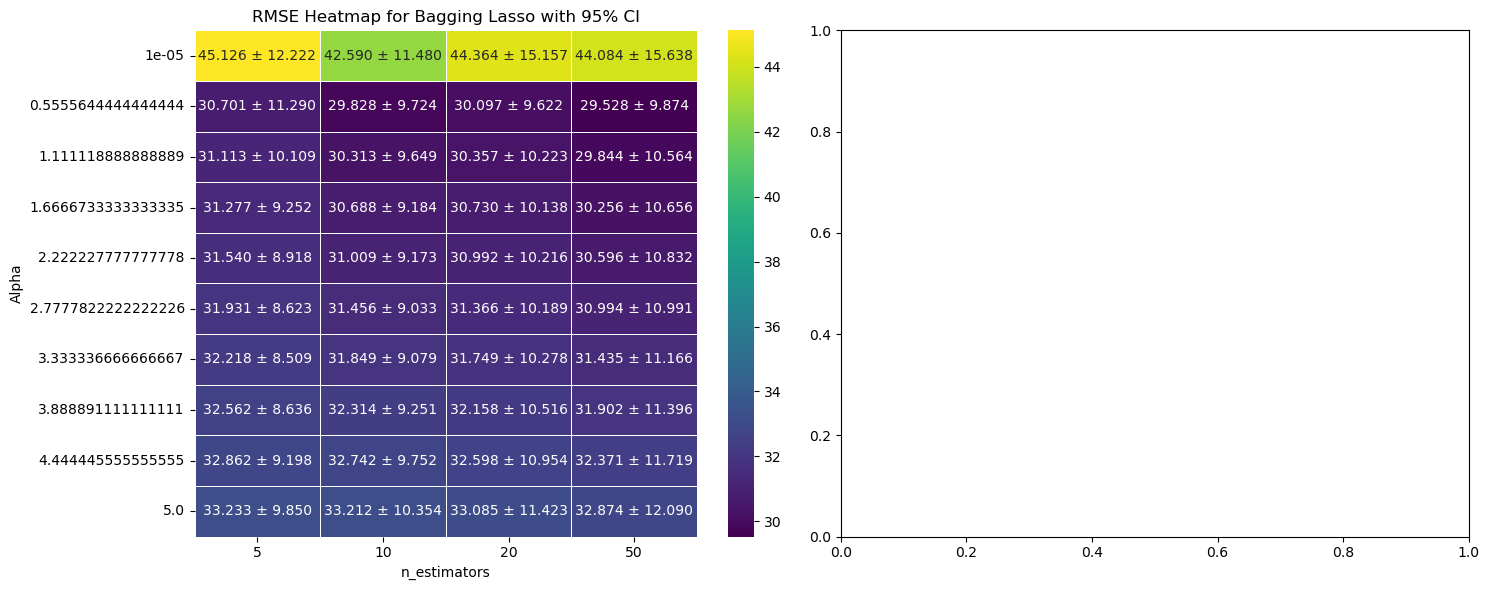

Final Results: {'Bagging Lasso': [(1e-05, 5, 45.126167613166224, 6.235581352891889), (1e-05, 10, 42.58987188403777, 5.857090119757792), (1e-05, 20, 44.3644168384857, 7.733399621679725), (1e-05, 50, 44.08406230287966, 7.978765324396429), (0.5555644444444444, 5, 30.700837687845052, 5.759966562376189), (0.5555644444444444, 10, 29.827755187112928, 4.961227569089501), (0.5555644444444444, 20, 30.096742827332015, 4.9090963214233785), (0.5555644444444444, 50, 29.528174201697176, 5.037970553523784), (1.111118888888889, 5, 31.113309954987777, 5.157500637460496), (1.111118888888889, 10, 30.312818354130183, 4.92282463353145), (1.111118888888889, 20, 30.357256687342147, 5.215847196789183), (1.111118888888889, 50, 29.843973663139046, 5.3896131085641645), (1.6666733333333335, 5, 31.27652190852052, 4.720461445182614), (1.6666733333333335, 10, 30.68809426057316, 4.685849500778899), (1.6666733333333335, 20, 30.730242894889567, 5.172653205310834), (1.6666733333333335, 50, 30.25571898206679, 5.4368184199

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))



for i, (model_name, model_results) in enumerate(results.items()):
    results_df = pd.DataFrame(model_results, columns=["Alpha", "n_estimators", "RMSE", "RMSE_Std"])
    results_df["CI"] = results_df["RMSE_Std"] * 1.96  # 95% Confidence Interval
    results_df["RMSE_CI"] = results_df.apply(lambda row: f'{row["RMSE"]:.3f} ± {row["CI"]:.3f}', axis=1)
    pivot_table = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE")
    pivot_labels = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE_CI")
    sns.heatmap(pivot_table, annot=pivot_labels, fmt="", cmap="viridis", linewidths=0.5, ax=axes[i])
    axes[i].set_xlabel("n_estimators")
    axes[i].set_ylabel("Alpha")
    axes[i].set_title(f"RMSE Heatmap for {model_name} with 95% CI")

plt.tight_layout()
plt.show()

print("Final Results:", results)


Stacked Model RMSE: 30.3600 ± 5.9334


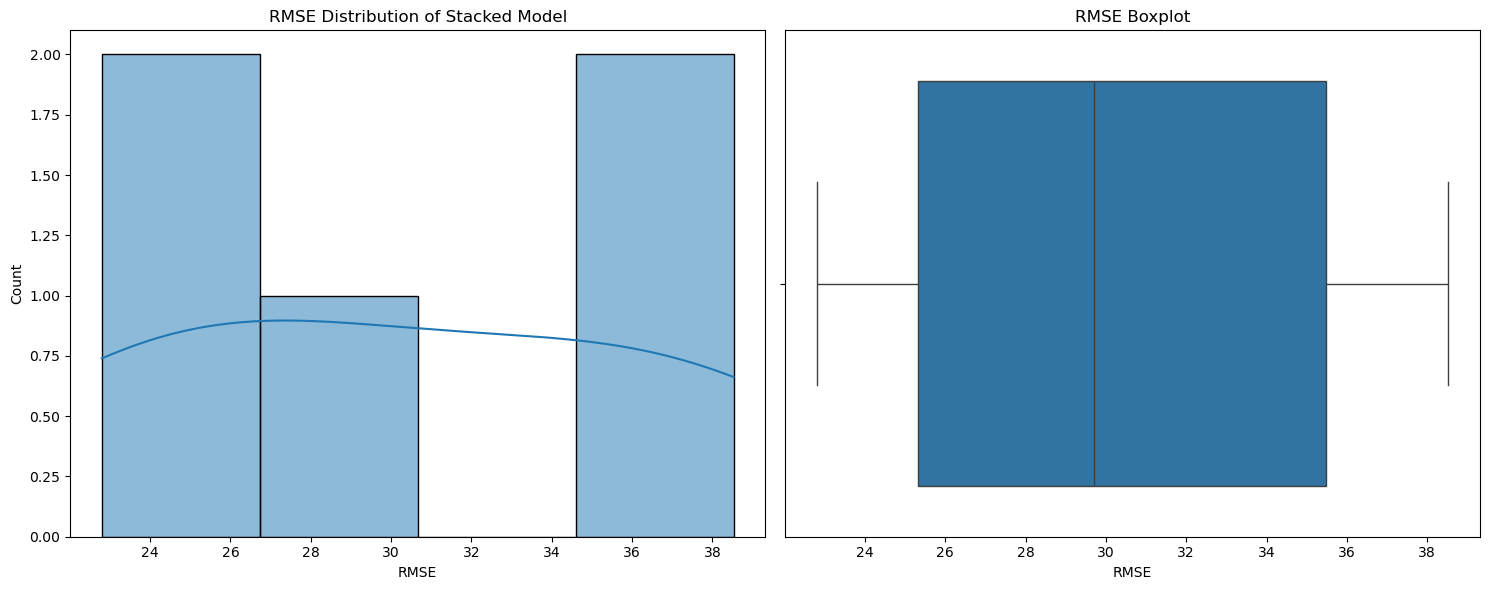

In [55]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

# Initialize wandb
#wandb.init(project="hybrid-model", entity="your_entity")

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Separate continuous and categorical feature indices
continuous_features = list(range(X.shape[1] - 5))  # Adjust as per your dataset
categorical_features = list(range(X.shape[1] - 5, X.shape[1]))  # Last 5 features

# Define models for Bagging Lasso and Decision Trees
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging_lasso', BaggingRegressor(estimator=Lasso(max_iter=100000), n_estimators=10, random_state=42))
])

tree_model = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('bagging_tree', BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42))
])

# Meta-model for stacking
stacked_model = StackingRegressor(
    estimators=[('lasso', lasso_model), ('tree', tree_model)],
    final_estimator=Ridge(alpha=1.0)
)

# Fit the stacking model and evaluate using outer cross-validation
results = []
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train the stacked model
    stacked_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = stacked_model.predict(X_test)
    
    # Calculate performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    results.append(rmse)

# Output final performance
mean_rmse = np.mean(results)
std_rmse = np.std(results)
print(f"Stacked Model RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")

# Log to wandb
#wandb.log({'RMSE': mean_rmse, 'RMSE Std': std_rmse})

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(results, kde=True, ax=axes[0])
axes[0].set_title("RMSE Distribution of Stacked Model")
axes[0].set_xlabel("RMSE")

sns.boxplot(x=results, ax=axes[1])
axes[1].set_title("RMSE Boxplot")
axes[1].set_xlabel("RMSE")

plt.tight_layout()
plt.show()

#wandb.finish()


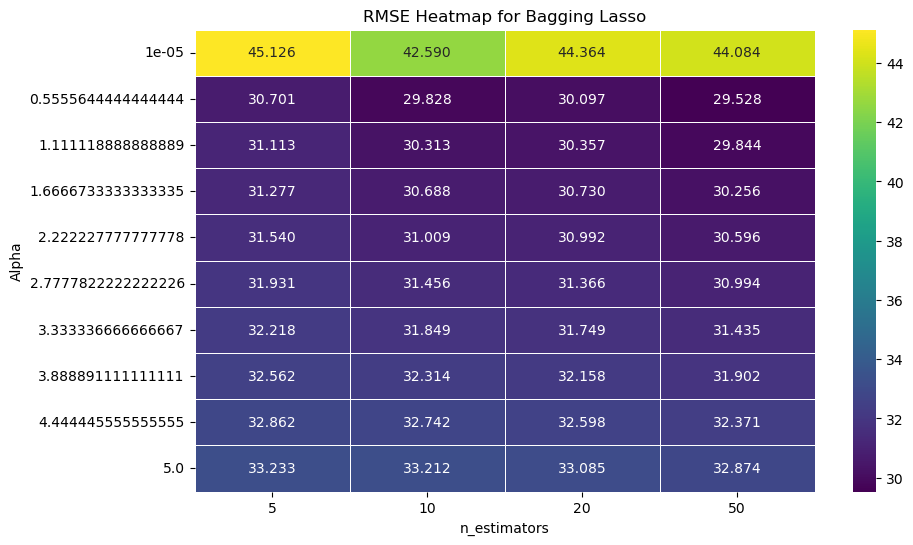

In [ ]:
#import sns
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame(results, columns=["Alpha", "n_estimators", "RMSE", "RMSE_Std"])
pivot_table = results_df.pivot(index="Alpha", columns="n_estimators", values="RMSE")

# display pivot table values as rounded to 3 decimal values
# Heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", linewidths=0.5)
plt.xlabel("n_estimators")
plt.ylabel("Alpha")
plt.title("RMSE Heatmap for Bagging Lasso")
plt.show()

In [38]:
import wandb
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

# Load and preprocess data
data = pd.read_csv('case1Data.csv')
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

def fill_nan(X, method='mean'):
    column_means = np.nanmean(X, axis=0)
    nan_matrix = np.isnan(X)
    X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    X[:, -4:] = np.round(X[:, -4:])  # Rounding categorical columns
    return X

X = fill_nan(X_nan, method='round_mean')

def standardize_data(X):
    X[:, -4:] = X[:, -4:].astype(int)
    scaler = StandardScaler()
    X[:, :-4] = scaler.fit_transform(X[:, :-4])
    enc = OneHotEncoder()
    X_cat = enc.fit_transform(X[:, -4:]).toarray()
    return np.concatenate((X[:, :-4], X_cat), axis=1)

X = standardize_data(X)

# 2-layer K-fold cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    #"Ridge": Ridge(max_iter=100000),
    "Lasso": Lasso(max_iter=100000)
}

param_grids = {
    "Ridge": {
        "alpha": np.linspace(1e-5, 10, 20)
    },
    "Lasso": {
        "alpha": np.linspace(1e-5, 10, 20)
    }
}

results = {}

for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=inner_cv, scoring='neg_mean_squared_error')
    outer_scores = []
    best_params_list = []
    
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params_list.append(frozenset(grid_search.best_params_.items()))  # Convert dict to hashable type
        
        y_pred = best_model.predict(X_test)
        test_score = mean_squared_error(y_test, y_pred)  # This gives MSE
        rmse = np.sqrt(test_score)  # This gives RMSE

        print(f"Fold RMSE: {rmse}")
        outer_scores.append(test_score)  # Store MSE (not R^2)

    
    mean_score = np.mean(outer_scores)
    
    # Find the most common best parameter set
    most_common_params = dict(Counter(best_params_list).most_common(1)[0][0])  

    print(f"{name} - RMSE: {np.sqrt(mean_score)}")
    print(f"{name} - Best Parameters: {most_common_params}")
    
    results[name] = {"RMSE": np.sqrt(mean_score), "Best Parameters": most_common_params}
    
    # wandb.init(project="2-layer-kfold-grid-search")
    # wandb.log({"Model": name, "RMSE": np.sqrt(mean_score), "Best Parameters": str(most_common_params)})  # Convert to string for logging
    # wandb.finish()

print("Final Results:", results)


Tuning Lasso...
Fold RMSE: 35.8977207512483
Fold RMSE: 31.72092118480822
Fold RMSE: 34.574901612088404
Lasso - RMSE: 34.10907512394618
Lasso - Best Parameters: {'alpha': 5.789477894736843}
Final Results: {'Lasso': {'RMSE': 34.10907512394618, 'Best Parameters': {'alpha': 5.789477894736843}}}


In [180]:
# print when a NaN value is found for each observation
print(data.isnull().sum(axis=1))


0     15
1     12
2     16
3     10
4     12
      ..
95    13
96    16
97     9
98    16
99    12
Length: 100, dtype: int64


Since there are missing values in more or less all observations, we need to find a smart way of filling them out - setting them to 0 is most likely too naive if we have highly correlating variables in dataset too.

In [27]:
#manual calculation of root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

#fit lasso model to all train data
alpha = 1.07
model = Lasso(alpha=alpha, random_state=42)
model.fit(X_train, y_train)
#predict on test data
y_pred = model.predict(X_test)
#calculate root mean squared error
rms = sqrt(mean_squared_error(y_test, y_pred))
print(rms)

37.46633402199812


In [123]:
np.unique(data.C_02)

array([72., nan])

In [6]:
## method 1 - use expected value imputation to fill in NaN values

#A matrix denoting if value is NaN
nan_matrix = np.isnan(X)

f_avg = np.asarray(np.mean(data,axis=0))[1:]
# if X[i] is NaN, replace with the average of the feature
for i in range(len(X)):
    for j in range(len(X[i])):
        if nan_matrix[i][j]:
            X[i][j] = f_avg[j] #slicing is better but this is easier to setup


In [ ]:
# # center the data to have mean 0 and variance 1
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# y = (y - np.mean(y)) / np.std(y)


In [ ]:
## method 2 - Use linear regression to fill in missing values

## ASK TA WHY THIS DOESN'T WORK
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Sample Data
np.random.seed(42)

# Step 1: Store NaN locations
nan_matrix = np.isnan(X)

# Step 2: Fill NaNs with column averages
column_means = np.nanmean(X, axis=0)
X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])  # Efficient column-wise assignment

# Step 3: Train linear regression models and predict missing values
for i in range(X.shape[1]):
    # Split data into missing and non-missing values
    missing = nan_matrix[:, i]
    present = ~missing

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X[present], y[present])

    # Predict missing values
    X_missing = X[missing]
    X[missing, i] = model.predict(X_missing)
# Convert back to DataFrame
df_filled = pd.DataFrame(X, columns=data.columns.drop('y'))

In [ ]:
# Display results
#check if there are any NaN values
print(df_filled.isnull().sum(axis=1))

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Length: 100, dtype: int64


In [183]:
X_train.shape

(80, 99)

In [187]:
#linear regression model to predict y from X
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

print(y_test)
print(y_pred)

1202.22718978639
[270.63620333  58.90373876 248.2937335  134.31305932 186.77032495
 155.32227947 235.00234276 284.45597869 260.27416868 375.82307301
 231.41466141 194.53679993  39.7022177  263.82929181 165.43351739
 289.69795389 219.66758656 141.18055872 106.47855156 163.8758382 ]
[226.50937798  77.79333192 293.93526992 134.73671693 236.12148237
 128.84643279 257.4949094  300.87038127 221.22532439 353.19990401
 209.93398444 198.85579879 109.38629142 269.86288407 204.68828206
 305.43990925 212.56055145 204.83406479 153.90493185 149.87183868]


In [155]:
# SVM model to predict y from X
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


6707.03886445971


In [108]:
#load in Xnew.csv
data_new = pd.read_csv('Case1Data_Xnew.csv')
X_new = np.array(data_new)

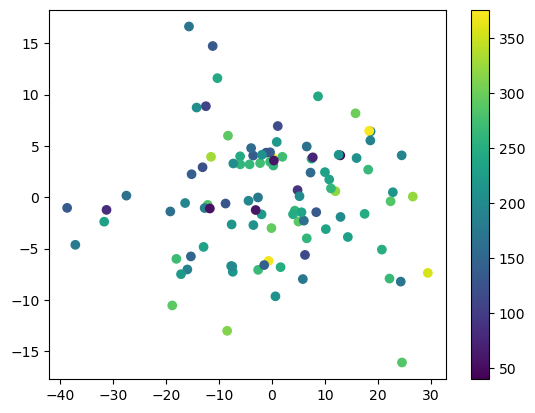

In [189]:
# visualize the data using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.colorbar()
plt.show()

In [ ]:
#polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(4), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


In [92]:
class RLSLasso:
    """
    Recursive Least Squares (RLS) with L1 regularization (LASSO).
    
    This class performs an online (incremental) update of regression weights.
    """

    def __init__(self, alpha=0.35, lambda_rls=1.0):
        self.alpha = alpha  # L1 regularization strength (like Lasso)
        self.lambda_rls = lambda_rls  # RLS regularization (prevents instability)
        self.P = None  # Inverse covariance matrix
        self.w = None  # Model coefficients

    def fit(self, X, y):
        """Batch training for initialization"""
        n_samples, n_features = X.shape
        self.P = np.eye(n_features) / self.lambda_rls
        self.w = np.zeros(n_features)

        for i in range(n_samples):
            self.partial_fit(X[i].reshape(1, -1), np.array([y[i]]))  # Update weights iteratively
    
    def partial_fit(self, X_new, y_new):
        """Online update using RLS with L1 shrinkage"""
        for i in range(X_new.shape[0]):
            x_t = X_new[i].reshape(-1, 1)  # Column vector
            y_t = y_new[i]
            
            # Kalman gain
            Px = self.P @ x_t
            gain = Px / (1 + x_t.T @ Px)

            # Standard RLS update
            self.w += gain.flatten() * (y_t - x_t.T @ self.w)

            # Apply L1 shrinkage (soft thresholding)
            self.w = np.sign(self.w) * np.maximum(np.abs(self.w) - self.alpha, 0)

            # Update P
            self.P = self.P - gain @ Px.T

    def predict(self, X):
        """Predict using learned weights"""
        return X @ self.w

In [96]:
# Wrapper for experiment
from sklearn.model_selection import train_test_split

#import model classes from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
#elastic net
from sklearn.linear_model import ElasticNet
#PCA
from sklearn.decomposition import PCA
#PLS
from sklearn.cross_decomposition import PLSRegression

def run_experiment(X_nan, y, model_class="linear_regression", *args, **kwargs):
    """
    Wrapper function to run an experiment.
    
    Parameters:
    X : array-like
        Feature matrix.
    y : array-like
        Target vector.
    model_class : class
        Model class (e.g., sklearn's classifiers like RandomForestClassifier).
    *args : tuple
        Positional arguments to pass to the model constructor.
    **kwargs : dict
        Keyword arguments to pass to the model constructor.
    
    Returns:
    dict
        A dictionary with model, predictions, and accuracy.
    """
    X = fill_nan(X_nan, method='mean')
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize model
    if model_class == "linear_regression":
        model = LinearRegression()
    elif model_class == "svm":
        model = SVR()
    elif model_class == "random_forest":
        model = RandomForestClassifier()
    elif model_class == "polynomial_regression":
        model = make_pipeline(PolynomialFeatures(*args), LinearRegression())
    elif model_class == "ridge_regression":
        model = Ridge()
    elif model_class == "lasso":
        model = Lasso(alpha=0.35)
    elif model_class == "rls_lasso": # rls good for sequential data, not good in this use case
        model = RLSLasso(alpha=0.0001,lambda_rls=10)
    elif model_class == "elastic_net":
        model = ElasticNet(alpha=0.3,l1_ratio=0.85)
    elif model_class == "PCR":
        model = make_pipeline(PCA(n_components=20), LinearRegression())
    elif model_class == "PLS":
        model = PLSRegression(n_components=40,max_iter=10000)
    else:
        raise ValueError("Invalid model class")


    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        "model": model,
        "predictions": y_pred,
        "RMSE": RMSE
    }

#run with ridge

print(run_experiment(X,y,model_class="ridge_regression"))
print(run_experiment(X,y,model_class="linear_regression"))
#print(run_experiment(X,y,model_class="polynomial_regression"), 16)
#print(run_experiment(X,y,model_class="svm"))
print(run_experiment(X,y,model_class="lasso"))
print(run_experiment(X,y,model_class="elastic_net"))
print(run_experiment(X,y,model_class="PLS"))



{'model': Ridge(), 'predictions': array([226.73862923,  75.81835163, 292.34619295, 125.86609104,
       229.11957405, 128.1303316 , 258.06330908, 289.3606733 ,
       220.28971578, 343.84199623, 210.24203943, 191.12415958,
       108.2989197 , 267.72115221, 201.3183806 , 301.07733222,
       221.74964282, 198.55272394, 149.63754477, 155.24549152]), 'RMSE': 32.989557547937494}
{'model': LinearRegression(), 'predictions': array([226.95749463,  77.75054085, 293.78413701, 134.48356412,
       236.36680985, 128.95516229, 257.49785841, 301.16627724,
       221.14393782, 353.19427707, 210.01150198, 199.00498787,
       109.56325915, 269.68269049, 204.56340689, 305.36302255,
       212.63931337, 204.96932692, 153.91096723, 149.92293482]), 'RMSE': 34.675888149474346}
{'model': Lasso(alpha=0.35), 'predictions': array([224.2822175 ,  66.23287356, 284.56706125, 124.3758193 ,
       217.60595701, 135.43840054, 252.80746505, 267.19272891,
       216.15603068, 335.3238944 , 238.09062741, 188.62660959

In [ ]:
#load in Case1Data.csv with pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Case1Data.csv')
#drop C_02 from data as 0 variance explained - 72.0 constant value
data = data.drop('C_02', axis=1)
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

from sklearn.linear_model import LinearRegression
def fill_nan(X, method='mean'):
    """"
    "Fill NaN values in a 2D array using the specified method""
    """
    if method == 'mean':
        column_means = np.nanmean(X, axis=0)
        nan_matrix = np.isnan(X)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    elif method == 'regression':
        nan_matrix = np.isnan(X)
        # Step 2: Fill NaNs with column averages
        column_means = np.nanmean(X, axis=0)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])  # Efficient column-wise assignment

        # Step 3: Train linear regression models and predict missing values
        for col in range(X.shape[1]):  
            missing_rows = np.where(nan_matrix[:, col])[0]  # Indices of missing values in this column
            
            if len(missing_rows) > 0:  # Only train if there were NaNs
                # Compute correlation, handle constant columns
                corr_matrix = np.corrcoef(X.T)
                corr_matrix = np.nan_to_num(corr_matrix)  # Replace NaNs/Infs with 0

                # Sort and select the 5 most correlated columns (excluding itself)
                correlation = np.abs(corr_matrix[col])
                sorted_indices = np.argsort(-correlation)  # Sort descending
                correlated_indices = [idx for idx in sorted_indices if idx != col][:5]  # Exclude itself

                # Ensure no NaNs in selected correlated columns
                valid_rows = ~np.any(nan_matrix[:, correlated_indices], axis=1)
                X_train, y_train = X[valid_rows][:, correlated_indices], X[valid_rows][:, col]

                if len(X_train) > 0:  # Ensure we have valid training data
                    # Train Linear Regression Model
                    model = LinearRegression()
                    model.fit(X_train, y_train)

                    # Predict missing values using the trained model
                    X_test = X[missing_rows][:, correlated_indices]
                    X[missing_rows, col] = model.predict(X_test)

    return X


X = fill_nan(X_nan, method='mean')


In [2]:
import numpy as np
import wandb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Initialize W&B project
#wandb.init(project="comptools-case1")

wandb.init(mode="offline")

# Generate synthetic data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective functions


def objective_elasticnet():
    # Access hyperparameters from wandb.config
    alpha = wandb.config.alpha
    l1_ratio = wandb.config.l1_ratio

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,max_iter=20000, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"neg_root_mean_mse": mean_score})  # Log only the target metric

    return mean_score




def objective_ridge():
    
    config = wandb.config
    model = Ridge(alpha=config.parameters.alpha, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"alpha": config.alpha, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_lasso():
    config = wandb.config
    model = Lasso(alpha=config.alpha, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"alpha": config.alpha, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_rf():
    config = wandb.config
    model = RandomForestRegressor(n_estimators=int(config.n_estimators), max_depth=int(config.max_depth), random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"n_estimators": config.n_estimators, "max_depth": config.max_depth, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_svr():
    config = wandb.config
    model = SVR(C=config.C, epsilon=config.epsilon)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"C": config.C, "epsilon": config.epsilon, "neg_root_mean_mse": mean_score})
    return mean_score

# # W&B Hyperparameter Optimization
# sweep_config = {
#     "method": "bayes",
#     "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
#     "parameters": {
#         "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
#         "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
#         "n_estimators": {"min": 10, "max": 200},
#         "max_depth": {"min": 1, "max": 10},
#         "C": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
#         "epsilon": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"}
#     }
# }

# W&B Hyperparameter Optimization
sweep_config = {
    "method": "bayes",
    "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
        "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
    }
}
sweep_id = wandb.sweep(sweep_config, project="comptools-case1-")

# Run optimization for different models
wandb.agent(sweep_id, function=objective_elasticnet, count=20)
# wandb.agent(sweep_id, function=objective_ridge, count=20)
# wandb.agent(sweep_id, function=objective_lasso, count=20)
# wandb.agent(sweep_id, function=objective_rf, count=20)
# wandb.agent(sweep_id, function=objective_svr, count=20)

print("Optimization completed!")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: w535epah
Sweep URL: https://wandb.ai/otovo-dtu-qa/comptools-case1-/sweeps/w535epah


wandb: Agent Starting Run: s2d31ujc with config:
wandb: 	alpha: 0.013243320458774428
wandb: 	l1_ratio: 0.9226650506412712
Exception in thread Thread-11 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_15804\177237783.py", line 23, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise Att

Optimization completed!
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x0000017375C347D0>> (for post_run_cell), with arguments args (<ExecutionResult object at 17372b11100, execution_count=2 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1736c962750, raw_cell="import numpy as np
import wandb
from sklearn.model.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X24sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [2]:
import wandb
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import wandb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# Generate synthetic data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective_elasticnet():
    print(wandb.config)
    alpha = wandb.config.alpha
    l1_ratio = wandb.config.l1_ratio

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"neg_root_mean_mse": mean_score})

    return mean_score

sweep_config = {
    "method": "bayes",
    "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
        "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
    }
}

# Initialize wandb BEFORE sweep and agent
wandb.init(project="comptools-case1-")

sweep_id = wandb.sweep(sweep_config, project="comptools-case1-")

wandb.agent(sweep_id, function=objective_elasticnet, count=20)

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kahmadi (otovo-dtu-qa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: i96c09ju
Sweep URL: https://wandb.ai/otovo-dtu-qa/comptools-case1-/sweeps/i96c09ju


wandb: Agent Starting Run: 0wsy3q2l with config:
wandb: 	alpha: 0.07616873860994129
wandb: 	l1_ratio: 0.4959325934003874
Exception in thread Thread-12 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^

{}


^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyke

{}


^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyker

{}


^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ip

{}


^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-pa

{}


^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ip

{}


^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyk

{}


^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipykernel

{}


^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipykernel

{}


^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipy

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DA5E76E7E0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1da567e2f90, execution_count=2 error_before_exec=None error_in_exec=[WinError 10053] An established connection was aborted by the software in your host machine info=<ExecutionInfo object at 1da567e3200, raw_cell="import wandb
import numpy as np
from sklearn.linea.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [2]:
import wandb
import time
def test_config():
    time.sleep(0.5)  # Add a 0.5-second delay

    print(f"config: {wandb.config}")
    print(f"alpha: {wandb.config.alpha}")

sweep_config = {
    "method": "bayes",
    "metric": {  # Added metric section
        "name": "loss",  # Replace "loss" with your actual metric name
        "goal": "minimize"  # Or "maximize", depending on your metric
    },
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
    }
}
wandb.run=None
wandb.init(project="test_config_simple")
sweep_id = wandb.sweep(sweep_config, project="test_config_simple")
wandb.agent(sweep_id, function=test_config, count=3)
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000191BFB195B0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 191bfea9ca0, raw_cell="import wandb
import time
def test_config():
    ti.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X34sZmlsZQ%3D%3D>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: uwahtq2n
Sweep URL: https://wandb.ai/otovo-dtu-qa/test_config_simple/sweeps/uwahtq2n


wandb: Agent Starting Run: ayjqx2gr with config:
wandb: 	alpha: 0.11390880406490515


config: {}


Exception in thread Thread-16 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_11764\2916602097.py", line 7, in test_config
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above 

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000191BFB195B0>> (for post_run_cell), with arguments args (<ExecutionResult object at 191bfea93d0, execution_count=2 error_before_exec=None error_in_exec=[WinError 10053] An established connection was aborted by the software in your host machine info=<ExecutionInfo object at 191bfea9ca0, raw_cell="import wandb
import time
def test_config():
    ti.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine